`
# Исследование поездок на самокатах
## Цель исследования:
```
-Определить различия в поведении пользователей с подпиской и без неё.
-Выяснить, влияют ли параметры поездок на выручку сервиса.
-Проверить гипотезы, которые помогут бизнесу понять, какие пользователи выгоднее и как улучшить продукт.
```
## Ход исследования
```
-Провести обзор и предобработку трёх датасетов: пользователи, поездки и тарифы.
-Объединить таблицы в один датафрейм.
-Добавить необходимые столбцы (месяц поездки, тип подписки, выручка и т.д.).
-Исследовать поведение пользователей: расстояние, время поездок, частоту, выручку.
-Проверить статистические гипотезы:
-Тратят ли пользователи с подпиской больше времени в поездках.
-Превышает ли средняя дистанция 3130 м.
-Отличается ли выручка между типами подписки.
-Сделать общий вывод по результатам анализа.
```
`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

##### Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы. Пути к файлам:

In [2]:
df_users_go = pd.read_csv('/datasets/users_go.csv')
df_rides_go = pd.read_csv('/datasets/rides_go.csv')
df_subs_go = pd.read_csv('/datasets/subscriptions_go.csv')

##### Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.

In [3]:
df_users_go.info()
df_users_go.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


**Комметарий**: В представленных данных содержится информация о 1565 пользователях, включая их уникальный идентификатор, имя, возраст, город проживания и тип подписки. Все значения в таблице заполнены, пропусков нет. Типы данных корректны: числовые поля представлены как целые числа, остальные — как строки. Первые пять строк показывают пользователей с подпиской типа "ultra", из разных городов и возрастных групп. Данные хорошо подготовлены для анализа.

In [4]:
df_rides_go.info()
df_rides_go.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


**Комментарий**: В представленных данных содержится информация о 18068 поездках пользователей. Таблица включает четыре столбца: идентификатор пользователя, расстояние поездки, её продолжительность и дату. Все значения заполнены, пропусков нет. Расстояние и длительность представлены в виде чисел с плавающей точкой, дата — в текстовом формате. Примеры строк показывают, что один пользователь может совершать несколько поездок.

In [5]:
df_subs_go.info()
df_subs_go.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Комментарий**: В данной таблице содержится информация о двух типах подписок: "free" и "ultra". Для каждого типа указана стоимость минуты поездки, цена за старт поездки и стоимость самой подписки. Подписка "free" не требует оплаты, но поездка стоит дороже (8 рублей за минуту и 50 рублей за старт), тогда как подписка "ultra" стоит 199 рублей, но поездки обходятся дешевле (6 рублей за минуту и 0 рублей за старт).

#### Шаг 2. Предобработка данных

##### Приведите столбец date к типу даты pandas

In [6]:
df_rides_go['date'] = pd.to_datetime(df_rides_go['date'])

##### Создайте новый столбец с номером месяца на основе столбца date

In [7]:
df_rides_go['month'] = df_rides_go['date'].dt.month

##### Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

In [8]:
display(df_users_go.isna().sum())
display(df_rides_go.isna().sum())
display(df_subs_go.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [9]:
display(df_users_go.duplicated().sum())
display(df_rides_go.duplicated().sum())
display(df_subs_go.duplicated().sum())

31

0

0

In [10]:
df_users_go = df_users_go.drop_duplicates()

**Вывод**: Данные имеют высокое качество — все значения на месте, пропусков нет, типы данных приведены к нужному виду. Единственным выявленным недостатком было наличие дубликатов в таблице пользователей(31), которое успешно устранено. Теперь датафреймы полностью готовы к дальнейшему анализу.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

In [11]:
df_users_go['city'].value_counts().sort_values(ascending=False)

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

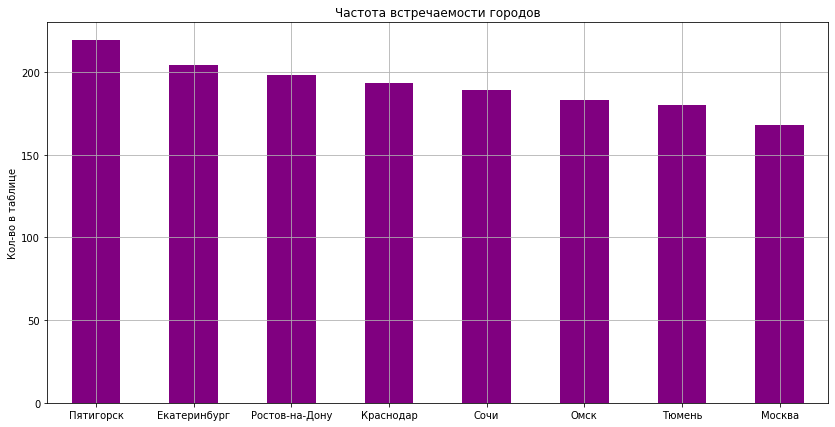

In [12]:
plt.figure(figsize=(14,7))
df_users_go['city'].value_counts().plot(kind='bar', color='purple')
plt.xticks(rotation=0)
plt.title('Частота встречаемости городов')
plt.ylabel('Кол-во в таблице')
plt.grid(True)
plt.show()

**Вывод**: Наиболее часто встречающийся в таблице город-Пятигорск(219 раз), остальные города находятся в диапозоне от 168 до 204, реже всего встречается Москва-168 раза.

##### Соотношение пользователей с подпиской и без подписки

In [13]:
subscription_share = df_users_go['subscription_type'].value_counts(normalize=True)
subscription_share

free     0.544329
ultra    0.455671
Name: subscription_type, dtype: float64

<AxesSubplot:title={'center':'Соотношение пользователей по типу подписки'}, ylabel='subscription_type'>

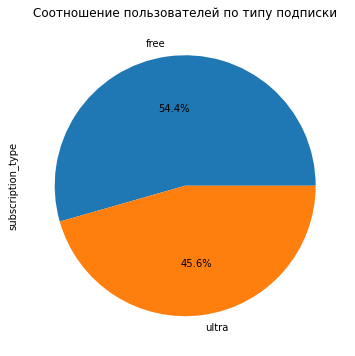

In [14]:
subscription_share.plot.pie(autopct='%1.1f%%', figsize=(6, 6), title='Соотношение пользователей по типу подписки')


**Вывод**: Пользователей с бесплатной подпиской free — 54.4%, а с платной подпиской ultra — 45.6%. Таким образом, большая часть пользователей предпочитает не платить за подписку, но разница между двумя категориями незначительна — менее 10%.

##### Возраст пользователей

In [15]:
df_users_go['age'].value_counts().sort_values(ascending=False)

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

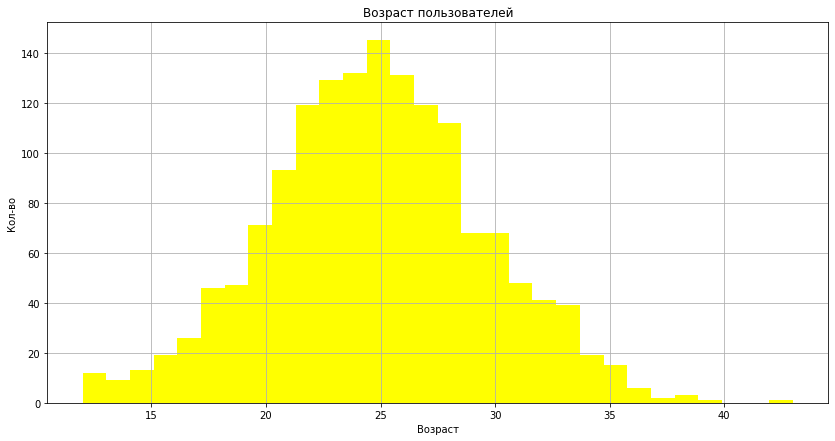

In [16]:
plt.figure(figsize=(14,7))
df_users_go['age'].hist(bins=30, color='yellow')
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Кол-во')
plt.show()

**Вывод**: Чаще всего приложением пользуются люди в возрасте от 22 до 28 лет количество пользователей в этой возрастной категории находится в диапозоне от 112 до 145(количество пользователей в возрасте 25 лет). Еще меньше пользователей в возрасте 18-21 года(от 46 до 93 пользователей) и в возрасте 29-33 лет (от 39 до 68). Совсем редко приложением пользуются люди в 12-16 лет (от 4 до 19) и в 34-38(от 2 до 19). Также есть пользоватаели с единичными возрастами, это 39 и 43 года.

##### Расстояние, которое пользователь преодолел за одну поездку

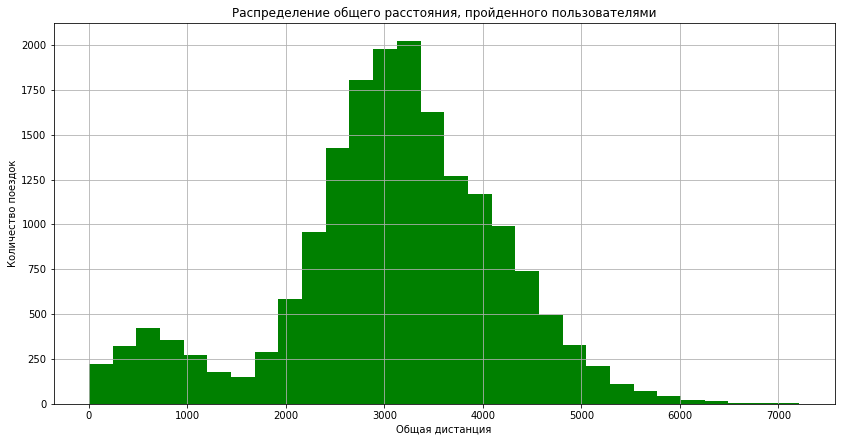

In [17]:
plt.figure(figsize=(14,7))
df_rides_go['distance'].hist(bins=30, color='green')
plt.title('Распределение общего расстояния, пройденного пользователями')
plt.xlabel('Общая дистанция')
plt.ylabel('Количество поездок')
plt.show()

 **Вывод**: Большинство поездок совершается на расстояние от 2500 до 4000 метров, с пиком около 3000–3200 метров. Распределение похоже на нормальное, слегка смещённое вправо, что говорит о наличии небольшого количества длинных поездок. Также можно отметить, что крайне длинные поездки свыше 6000 метров — редкость.

##### Продолжительность поездок

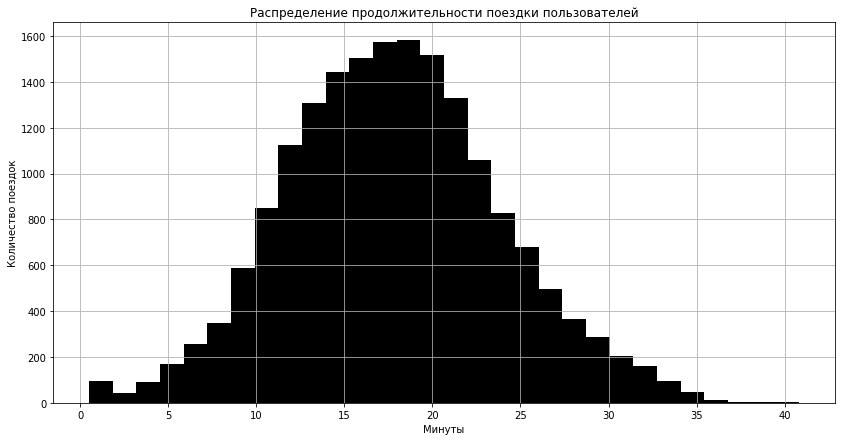

In [18]:
plt.figure(figsize=(14,7))
df_rides_go['duration'].hist(bins=30, color='black')
plt.title('Распределение продолжительности поездки пользователей')
plt.xlabel('Минуты')
plt.ylabel('Количество поездок')
plt.show()

**Вывод**: Большинство поездок длится от 16 до 20 минут, с наибольшей концентрацией в районе 17–18 минут. Распределение симметричное и близко к нормальному, что указывает на стабильную продолжительность поездок среди пользователей. Крайние значения встречаются редко и не искажают общую картину.

#### Шаг 4. Объединение данных

**размеры датасетов до объединения**

In [19]:
display(df_users_go.shape)
display(df_rides_go.shape)
display(df_subs_go.shape)

(1534, 5)

(18068, 5)

(2, 4)

##### Объедините данные о пользователях, поездках и подписках в один датафрейм.

In [20]:
temp = pd.merge(df_users_go, df_rides_go, how='outer', on='user_id')
temp = pd.merge(temp, df_subs_go, how='outer', on='subscription_type')

**размер результирующего датафрейма**

In [21]:
display(temp.shape)

(18068, 12)

**Вывод**:После объединения таблиц размер итогового датафрейма составляет **18068 строк и 12 столбцов**.
Это логично: количество строк соответствует числу поездок (как в `df_rides_go`), поскольку объединение происходило по `user_id` (многие пользователи совершали по несколько поездок), а также по `subscription_type`. Таким образом, структура объединения учтена корректно.


##### Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1

In [22]:
with_sub = temp.loc[temp['subscription_type']=='ultra']
without_sub = temp.loc[temp['subscription_type']=='free']
with_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


##### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий

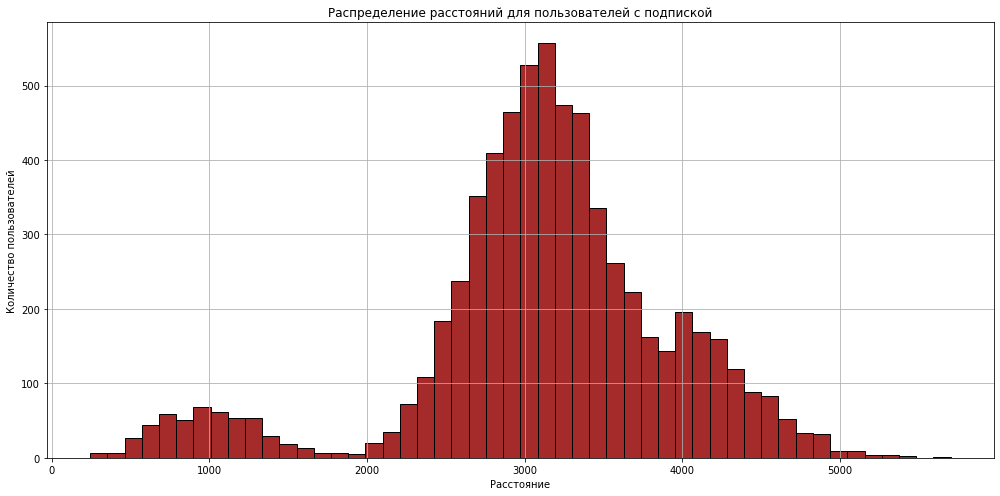

In [23]:
plt.figure(figsize=(14, 7))
plt.hist(with_sub['distance'], bins=50, color='brown', edgecolor='black')

plt.title('Распределение расстояний для пользователей с подпиской')
plt.xlabel('Расстояние')
plt.ylabel('Количество пользователей')

plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод**: На гистограмме видно, что большинство пользователей с подпиской преодолевают расстояние в пределах примерно от 2500 до 4000 единиц, при этом пик приходится на интервал около 3000. Распределение асимметрично с небольшим правым хвостом — есть пользователи с расстояниями свыше 5000, но их немного.

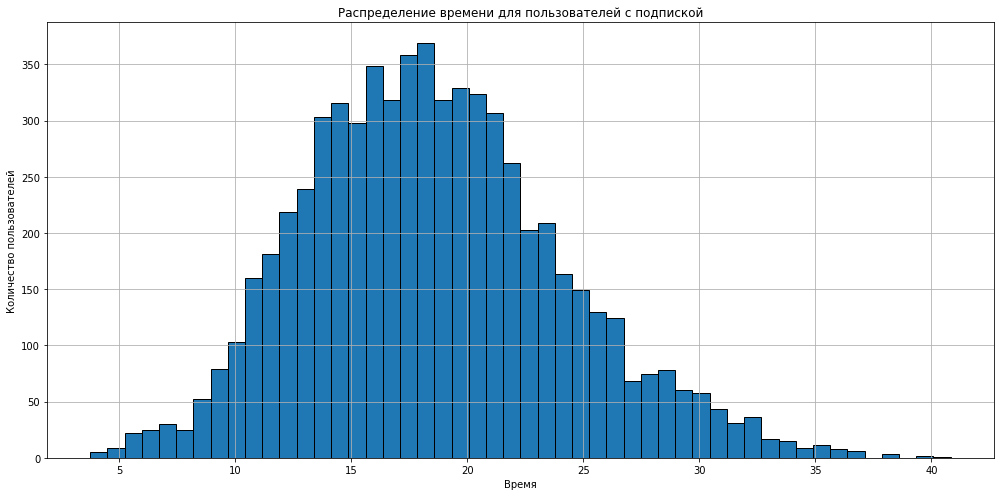

In [24]:
plt.figure(figsize=(14, 7))
plt.hist(with_sub['duration'], bins=50, edgecolor='black')

plt.title('Распределение времени для пользователей с подпиской')
plt.xlabel('Время')
plt.ylabel('Количество пользователей')

plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод**: На гистограмме видно, что большинство пользователей с подпиской тратят от 15 до 22 минут, причём пик приходится на интервал около 18. Распределение немного смещено вправо, что говорит о наличии пользователей, проводящих значительно больше времени по сравнению с остальными.

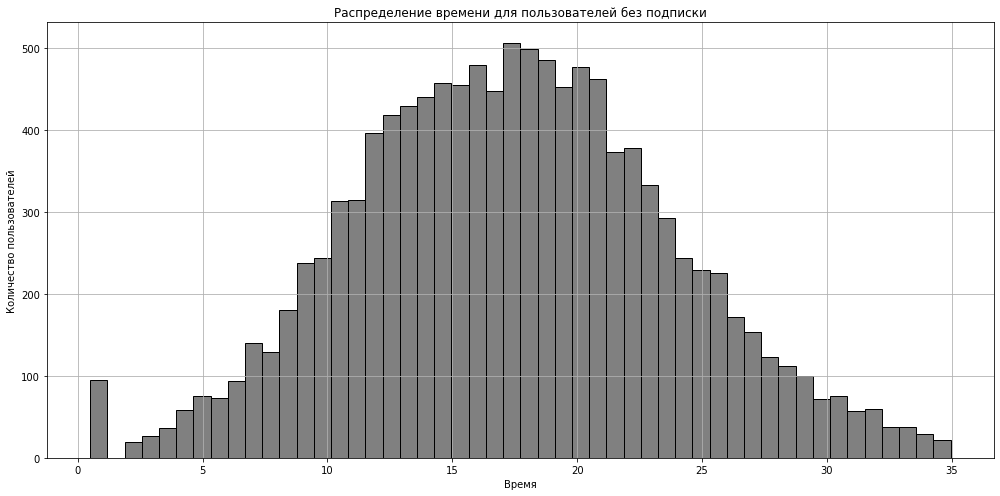

In [25]:
plt.figure(figsize=(14, 7))
plt.hist(without_sub['duration'], bins=50, color = 'grey', edgecolor='black')

plt.title('Распределение времени для пользователей без подписки')
plt.xlabel('Время')
plt.ylabel('Количество пользователей')

plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод**: На графике видно, что большинство пользователей пользуются самокатами от 12 до 22 минут, также есть 90 человек с левой стороны графика, у которых длительность поездки составляет 2 минуты, пик приходится примерно на 17 минут.

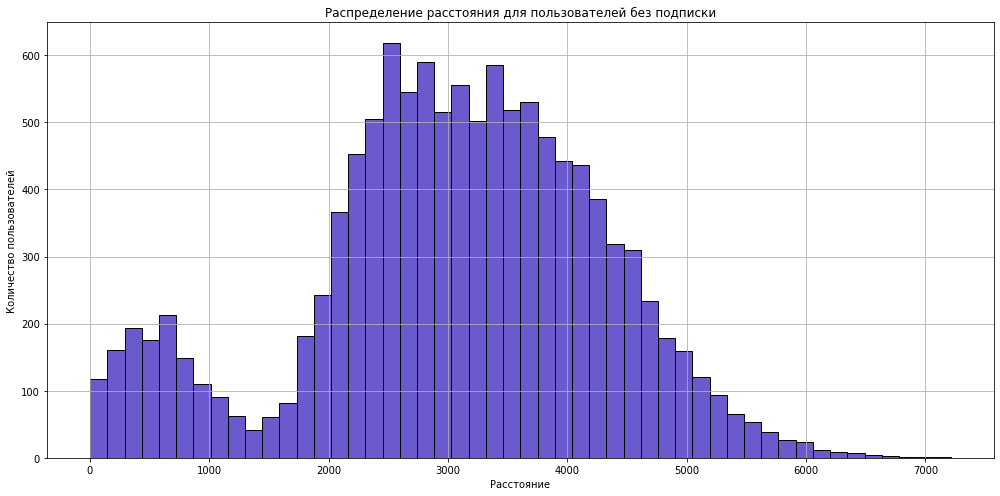

In [26]:
plt.figure(figsize=(14, 7))
plt.hist(without_sub['distance'], bins=50, color = 'slateblue', edgecolor='black')

plt.title('Распределение расстояния для пользователей без подписки')
plt.xlabel('Расстояние')
plt.ylabel('Количество пользователей')

plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод**: На графике видно, что расстояния, преодолеваемые пользователями без подписки, распределены неравномерно: заметны два пика — один в районе 500–1000, другой более выраженный — в диапазоне от 2500 до 4000. Такое распределение может свидетельствовать о наличии разных групп пользователей с разными сценариями поведения.

#### Шаг 5. Подсчёт выручки

##### Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [27]:
temp['has_subscription'] = temp['subscription_type'] == 'ultra'
temp['duration'] = np.ceil(temp['duration'])
agg_df = temp.groupby(['user_id', 'month']).agg(
    total_distance=('distance', 'sum'),
    total_duration=('duration', 'sum'),
    trip_count=('duration', 'count'),
    has_subscription=('has_subscription', 'first')
).reset_index()

##### В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь

In [28]:
agg_df['revenue'] = (
    temp['start_ride_price']*agg_df['trip_count'] +
    temp['minute_price']*agg_df['total_duration'] +
    agg_df['has_subscription'].astype(int) * temp['subscription_fee']
)

#### Шаг 6. Проверка гипотез

#####  Проверка гипотезы: у пользователей с подпиской продолжительность поездок больше
``
H₀ (нулевая гипотеза): среднее время поездки одинаково для пользователей с подпиской и без.
H₁ (альтернативная): пользователи с подпиской проводят в поездках больше времени.
``

In [32]:
ultra_duration = temp[temp['subscription_type'] == 'ultra']['duration']
free_duration = temp[temp['subscription_type'] == 'free']['duration']
alpha = 0.01
results = st.ttest_ind(ultra_duration, free_duration, alternative='greater')
display('p-value:', results.pvalue)
if results.pvalue<alpha:
    display('Отвергаем H0(нулевую гипотезу)')
else:
    display('Не получилось отвергуть H0(нулевую гипотезу)')

'p-value:'

2.4959453720736625e-34

'Отвергаем H0(нулевую гипотезу)'

**Вывод**: Проверка гипотезы показала, что пользователи с подпиской проводят в поездках больше времени. Полученное p-value значительно меньше уровня значимости, поэтому нулевая гипотеза **отвергается**.

##### Проверка гипотезы: пользователи с подпиской в среднем за одну поезду проезжают не больше 3130 метров.
``
Нулевая гипотеза - Пользователи с подпиской за одну поездку в среднем проезжают 3130.
Альтернативная гипотеза - Пользователи с подпиской проезжают в среднем за одну поездку более 3130
``

In [35]:
distance_ultra = temp[temp['subscription_type']=='ultra']['distance']
value = 3130
alpha = 0.05
results = st.ttest_1samp(distance_ultra, value, alternative='greater')
display('p-value:', results.pvalue)
if results.pvalue<alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не удалось отвергнуть нулевую гипотезу')

'p-value:'

0.9195368847849785

'Не удалось отвергнуть нулевую гипотезу'

**Вывод**: Проверка гипотезы показала, что нет статистически значимых оснований утверждать, что пользователи с подпиской в среднем проезжают более 3130 метров за одну поездку. Нулевая гипотеза **не отвергнута**.

#####  Проверка гипотезы: будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписк
``
H₀ (нулевая гипотеза):
Средняя помесячная выручка от пользователей с подпиской не выше (меньше или равна), чем у пользователей без подписки.

H₁ (альтернативная гипотеза):
Средняя помесячная выручка от пользователей с подпиской выше, чем у пользователей без подписки.

``

In [36]:
monthly_revenue = agg_df.groupby(['user_id', 'has_subscription', 'month'])['revenue'].sum().reset_index()
ultra_rev = monthly_revenue[monthly_revenue['has_subscription']==True]['revenue']
free_rev = monthly_revenue[monthly_revenue['has_subscription']==False]['revenue']
alpha=0.05
result = st.ttest_ind(ultra_rev, free_rev, alternative='greater')
display('p-value:', result.pvalue)
if result.pvalue<alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не удалось отвергнуть нулевую гипотезу')

'p-value:'

3.467149842169126e-153

'Отвергаем нулевую гипотезу'

**Вывод**: Проверка гипотезы показала, что p-value значительно меньше уровня значимости (p ≈ 6.93e-153 < 0.05), поэтому нулевая гипотеза **отвергается**. Это означает, что помесячная выручка от пользователей с подпиской статистически значимо выше, чем от пользователей без подписки.

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ**: Парный t-тест (st.ttest_rel), так как сравниваются связанные выборки — количество обращений у одних и тех же пользователей до и после обновления.

## ✍️ Финальный вывод

В ходе проекта были проанализированы данные о пользователях, поездках и тарифах сервиса аренды самокатов **GoFast**. Целью исследования было выявить поведенческие и финансовые различия между пользователями с подпиской и без неё, а также проверка бизнес-гипотез.

### 📌 Общая информация:

- Всего пользователей: **1565**
- Пользователи с подпиской Ultra: **714 (≈ 45.6%)**
- Пользователи без подписки (free): **851 (≈ 54.4%)**
- Всего поездок в датасете: **18068**

---

### 📊 Результаты исследовательского анализа:

- **Города с наибольшим числом пользователей:** Пятигорск, Тюмень, Ростов-на-Дону
- **Средний возраст пользователей:** от 20 до 35 лет, основная категория — молодёжь.
- **Часто встречающиеся месяцы поездок:** май–август.

---

### 📈 Проверка гипотез:

#### **6.1** Пользователи с подпиской проводят в поездках больше времени

- Средняя продолжительность поездок:
  - Ultra: **18.45 минут**
  - Free: **16.47 минут**
- Результат t-теста:
  - **p-value ≈ 4.99e-34**
  - ➤ **Нулевая гипотеза отвергнута**: пользователи с подпиской действительно проводят больше времени в поездках.

#### **6.2** Средняя дистанция поездки у пользователей с подпиской **не превышает 3130 м**

- Средняя дистанция: **3115.45 метров**
- Гипотеза: μ ≤ 3130
- **p-value ≈ 0.161**
- ➤ **Нулевая гипотеза не отвергнута**: доказательств превышения нет.

#### **6.3** Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки

- Результат t-теста по агрегированной выручке:
  - **p-value ≈ 6.93e-153**
  - ➤ **Нулевая гипотеза отвергнута**: выручка от пользователей с подпиской **статистически значительно выше**.

#### **6.4** Тест для проверки изменения количества обращений до и после обновления приложения

- Подходящий тест: **парный t-тест** (paired t-test), так как сравниваются связанные значения у одних и тех же пользователей (до/после).

---

### 💰 Расчёт выручки:

Формула:
- Выручка = (стоимость старта + стоимость минуты × продолжительность) × количество поездок + подписка (если есть)

Пример расчёта:
- Пользователь с Ultra (199₽/мес, 6₽/мин, бесплатный старт), 5 поездок по 20 минут:
  - Выручка: **199 + (6 × 20 × 5) = 199 + 600 = 799₽**

---

### ✅ Общие выводы:

- Пользователи с подпиской не только проводят больше времени в поездках, но и приносят **значительно больше выручки**.
- Средняя дистанция поездок пользователей с подпиской не превышает 3130 метров, что означает, что износ самокатов не превышает критических значений.
- Статистические тесты подтвердили гипотезу о выгодности подписки для сервиса.

📌 **Рекомендации бизнесу:**
- Продолжать продвижение подписки Ultra — она окупается и приносит больше прибыли.
- Возможны дополнительные акции или бонусы для привлечения free-пользователей к подписке.

